In [1]:
import os
from extract_features import *
import random
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import euclidean

In [2]:
test_data_dir = '/home/caffe/images/china_drinks_test_data/all_cropped_images'
china_drinks_production_sku_model = '/datadrive/models/sku_classification/tf/p100-test/20181026/frozen_inception_v3.pb'
china_drinks_production_vocab_map = '/datadrive/models/sku_classification/tf/p100-test/20181026/ml_vocab_map.txt'
china_drinks_production_output_tensor_name = 'InceptionV3/Predictions/Reshape_1:0'
china_drinks_production_phase_name = False

china_drinks_embedding_sku_model = '/home/caffe/achu/frozen_models/latest_china.pb'
china_drinks_embedding_vocab_map = '/home/caffe/achu/models/ml_vocab_map_china_drinks_1_16_19.txt'
china_drinks_embedding_output_tensor_name = 'Logits/BiasAdd:0'
china_drinks_feature_tensor_name = 'embeddings:0'
china_drinks_embedding_phase_name = True

QA_PROD_THRESHOLD = 0.7
DISTANCE_THRESHOLD = 0.5

In [3]:
test_images = get_images(test_data_dir)

In [4]:
subset_test_images = random.sample(test_images, 300)
test_labels = [int(label.split('/')[-2]) for label in subset_test_images]

In [5]:
def infer(test_image_paths, test_labels, sku_model, vocab_map, output_tensor_name, if_phase_tensor = False, image_size = 299):
    raw_network_outputs = get_embeddings(test_image_paths, sku_model, features_tensor_name = output_tensor_name, phase_train_tensor = if_phase_tensor, image_size = image_size)
    vocab_map = pd.read_csv(china_drinks_production_vocab_map, header = None)
    pred_sku_dict = dict(zip(vocab_map[1].tolist(), vocab_map[0].tolist()))
    predictions = [np.argmax(pred) for pred in raw_network_outputs]
    conf_scores = [pred[np.argmax(pred)] for pred in raw_network_outputs]
    predictions_actual = [int(pred_sku_dict[pred]) for pred in predictions]
    print ('Accuracy_score: ', accuracy_score(test_labels, predictions_actual))
    return predictions_actual, conf_scores

In [26]:
china_drinks_production_predictions, china_drinks_production_scores = infer(subset_test_images, test_labels, china_drinks_production_sku_model, china_drinks_production_vocab_map, china_drinks_production_output_tensor_name, china_drinks_production_phase_name, image_size = 299)

Model filename: /datadrive/models/sku_classification/tf/p100-test/20181026/frozen_inception_v3.pb
('Total size: ', 300)
('Accuracy_score: ', 0.71)


In [7]:
china_drinks_embedding_predictions, china_drinks_embedding_scores = infer(subset_test_images, test_labels, china_drinks_embedding_sku_model, china_drinks_embedding_vocab_map, china_drinks_embedding_output_tensor_name, china_drinks_embedding_phase_name, image_size = 256)

Model filename: /home/caffe/achu/frozen_models/latest_china.pb
('Total size: ', 300)
('Accuracy_score: ', 0.12333333333333334)


In [8]:
def qa_performance(test_labels, predictions, conf_scores, should_qa_threshold = 0.7):
    n_correct = 0
    n_wrong = 0
    n_qa = 0
    n_no_qa = 0
    n_correct_but_sent_to_qa = 0
    n_wrong_and_sent_to_qa = 0
    n_correct_and_not_sent_to_qa = 0
    n_wrong_but_not_sent_to_qa = 0
    for i in range(len(test_labels)):
        if conf_scores[i]<should_qa_threshold:
            n_qa += 1
            if test_labels[i]==predictions[i]:
                n_correct += 1
                n_correct_but_sent_to_qa += 1
            else:
                n_wrong_and_sent_to_qa+=1
                n_wrong+=1
        else:
            n_no_qa += 1
            if test_labels[i]==predictions[i]:
                n_correct += 1
                n_correct_and_not_sent_to_qa += 1
            else:
                n_wrong_but_not_sent_to_qa += 1
                n_wrong+=1
    print ('n_correct: ', n_correct)
    print ('n_wrong: ', n_wrong)
    print ('n_qa: ', n_qa)
    print ('n_no_qa', n_no_qa)
    print ('n_wrong_and_sent_to_qa: ', n_wrong_and_sent_to_qa)
    print ('n_correct_and_not_sent_to_qa: ', n_correct_and_not_sent_to_qa)
    print ('n_correct_but_sent_to_qa: ', n_correct_but_sent_to_qa)
    print ('n_wrong_but_not_sent_to_qa: ', n_wrong_but_not_sent_to_qa)
    print ('QA rule precision: n_wrong_and_sent_to_qa/[n_wrong_and_sent_to_qa+n_correct_but_sent_to_qa]: ', n_wrong_and_sent_to_qa/float(n_wrong_and_sent_to_qa+n_correct_but_sent_to_qa))
    print ('QA rule recall: n_wrong_and_sent_to_qa/[n_wrong_and_sent_to_qa+n_wrong_but_not_sent_to_qa]: ', n_wrong_and_sent_to_qa/float(n_wrong_and_sent_to_qa+n_wrong_but_not_sent_to_qa))
    print ('Box level accuracy before QA: ', n_correct/float(n_correct+n_wrong))
    print ('Box level accuracy after QA: ', (n_correct+n_wrong_and_sent_to_qa)/float(n_correct+n_wrong))

In [27]:
qa_performance(test_labels, china_drinks_production_predictions, china_drinks_production_scores, should_qa_threshold = QA_PROD_THRESHOLD)

('n_correct: ', 213)
('n_wrong: ', 87)
('n_qa: ', 99)
('n_no_qa', 201)
('n_wrong_and_sent_to_qa: ', 55)
('n_correct_and_not_sent_to_qa: ', 169)
('n_correct_but_sent_to_qa: ', 44)
('n_wrong_but_not_sent_to_qa: ', 32)
('QA rule precision: n_wrong_and_sent_to_qa/[n_wrong_and_sent_to_qa+n_correct_but_sent_to_qa]: ', 0.5555555555555556)
('QA rule recall: n_wrong_and_sent_to_qa/[n_wrong_and_sent_to_qa+n_wrong_but_not_sent_to_qa]: ', 0.632183908045977)
('Box level accuracy before QA: ', 0.71)
('Box level accuracy after QA: ', 0.8933333333333333)


In [10]:
def get_approx_cluster_centers(sku_ids, train_data_dir, model_dir, feature_tensor_name = 'embeddings:0', image_size = 256, if_phase=True, no_of_samples_used_in_center_calculation = 1500):
    sku_wise_req_image_counts = {}
    all_the_req_image_paths = []
    training_skus = [int(float(sku)) for sku in os.listdir(train_data_dir)]
    training_skus_actual_names = os.listdir(train_data_dir)
    skus_with_no_training_images = []
    sku_wise_cluster_centers = {}
    for sku_id in sku_ids:
        if sku_id in training_skus:
            sku_path = train_data_dir+'/'+training_skus_actual_names[training_skus.index(sku_id)]
            sku_image_paths = [sku_path+'/'+im for im in os.listdir(sku_path)]
            req_image_paths = random.sample(sku_image_paths, min(no_of_samples_used_in_center_calculation, len(sku_image_paths)))
            all_the_req_image_paths += req_image_paths
            sku_wise_req_image_counts[sku_id] = len(req_image_paths)
        else:
            skus_with_no_training_images += [sku_id]
    all_the_req_embeddings = get_embeddings(all_the_req_image_paths, model_dir, chunk_size = 500, features_tensor_name=feature_tensor_name, phase_train_tensor=True, image_size=256)
    idx = 0
    for sku in sku_wise_req_image_counts:
        # print (Debug st: sku_wise_req_image_counts[sku], idx)
        if sku_wise_req_image_counts[sku]>1:
            req_arr = np.asarray(all_the_req_embeddings[idx:idx+sku_wise_req_image_counts[sku]])
            #print ('Debug st len(req_arr): ', len(req_arr))
            sku_wise_cluster_centers[sku] = req_arr.mean(axis = 0)
        idx += sku_wise_req_image_counts[sku]
    return sku_wise_cluster_centers

In [11]:
test_sku_set = set(test_labels)
cluster_centers_dict = get_approx_cluster_centers(test_sku_set, '/home/caffe/images/china_drinks_train_data_latest_full/all_cropped_images', china_drinks_embedding_sku_model, image_size = 256)

Model filename: /home/caffe/achu/frozen_models/latest_china.pb
('Total size: ', 175285)
('current chunk i: ', 500)
('current chunk i: ', 1000)
('current chunk i: ', 1500)
('current chunk i: ', 2000)
('current chunk i: ', 2500)
('current chunk i: ', 3000)
('current chunk i: ', 3500)
('current chunk i: ', 4000)
('current chunk i: ', 4500)
('current chunk i: ', 5000)
('current chunk i: ', 5500)
('current chunk i: ', 6000)
('current chunk i: ', 6500)
('current chunk i: ', 7000)
('current chunk i: ', 7500)
('current chunk i: ', 8000)
('current chunk i: ', 8500)
('current chunk i: ', 9000)
('current chunk i: ', 9500)
('current chunk i: ', 10000)
('current chunk i: ', 10500)
('current chunk i: ', 11000)
('current chunk i: ', 11500)
('current chunk i: ', 12000)
('current chunk i: ', 13500)
('current chunk i: ', 14000)
('current chunk i: ', 14500)
('current chunk i: ', 15000)
('current chunk i: ', 15500)
('current chunk i: ', 16000)
('current chunk i: ', 16500)
('current chunk i: ', 17000)
('cu

('current chunk i: ', 140500)
('current chunk i: ', 141000)
('current chunk i: ', 141500)
('current chunk i: ', 142000)
('current chunk i: ', 142500)
('current chunk i: ', 143000)
('current chunk i: ', 143500)
('current chunk i: ', 144000)
('current chunk i: ', 144500)
('current chunk i: ', 145000)
('current chunk i: ', 145500)
('current chunk i: ', 146000)
('current chunk i: ', 146500)
('current chunk i: ', 147000)
('current chunk i: ', 147500)
('current chunk i: ', 148000)
('current chunk i: ', 148500)
('current chunk i: ', 149000)
('current chunk i: ', 149500)
('current chunk i: ', 150000)
('current chunk i: ', 150500)
('current chunk i: ', 151000)
('current chunk i: ', 151500)
('current chunk i: ', 152000)
('current chunk i: ', 152500)
('current chunk i: ', 153000)
('current chunk i: ', 153500)
('current chunk i: ', 154000)
('current chunk i: ', 154500)
('current chunk i: ', 155000)
('current chunk i: ', 155500)
('current chunk i: ', 156000)
('current chunk i: ', 156500)
('current 

In [12]:
china_drinks_test_embeddings = get_embeddings(subset_test_images, china_drinks_embedding_sku_model, chunk_size = 500, features_tensor_name = china_drinks_feature_tensor_name, phase_train_tensor = china_drinks_embedding_phase_name, image_size = 256)

Model filename: /home/caffe/achu/frozen_models/latest_china.pb
('Total size: ', 300)


In [28]:
distances_from_centroids_to_positives = []
distances_from_centroids_to_negatives = []
two_step_predictions = []

for i in range(len(test_labels)):
    if test_labels[i] in cluster_centers_dict:
        centroid_distance = euclidean(china_drinks_test_embeddings[i], cluster_centers_dict[test_labels[i]])
        prod_pred = china_drinks_production_predictions[i]
        prod_pred_score = china_drinks_production_scores[i]
        
        if prod_pred == test_labels[i]:
            distances_from_centroids_to_positives += [centroid_distance]
        else:
            distances_from_centroids_to_negatives += [centroid_distance]
        #adding any missed wrong preds which might pass as correct
        #wrong and not sent to qa number should be better
        if prod_pred_score > QA_PROD_THRESHOLD and centroid_distance < 0.5:
            #setting the conf score to 0.01 to be included for qa
            china_drinks_production_scores[i] = 0.01
        #removing any correct preds that might be sent to QA
        elif prod_pred_score < QA_PROD_THRESHOLD and centroid_distance > 1.2:
            #setting the conf score to 0.8 to be not included for qa
            china_drinks_production_scores[i] = 0.8

In [29]:
qa_performance(test_labels, china_drinks_production_predictions, china_drinks_production_scores, should_qa_threshold = QA_PROD_THRESHOLD)

('n_correct: ', 213)
('n_wrong: ', 87)
('n_qa: ', 125)
('n_no_qa', 175)
('n_wrong_and_sent_to_qa: ', 47)
('n_correct_and_not_sent_to_qa: ', 135)
('n_correct_but_sent_to_qa: ', 78)
('n_wrong_but_not_sent_to_qa: ', 40)
('QA rule precision: n_wrong_and_sent_to_qa/[n_wrong_and_sent_to_qa+n_correct_but_sent_to_qa]: ', 0.376)
('QA rule recall: n_wrong_and_sent_to_qa/[n_wrong_and_sent_to_qa+n_wrong_but_not_sent_to_qa]: ', 0.5402298850574713)
('Box level accuracy before QA: ', 0.71)
('Box level accuracy after QA: ', 0.8666666666666667)


(array([34., 38., 31., 22., 22., 22., 53., 46., 24.,  7.]),
 array([0.29699877, 0.4228686 , 0.54873843, 0.67460826, 0.80047809,
        0.92634793, 1.05221776, 1.17808759, 1.30395742, 1.42982725,
        1.55569708]),
 <a list of 10 Patch objects>)

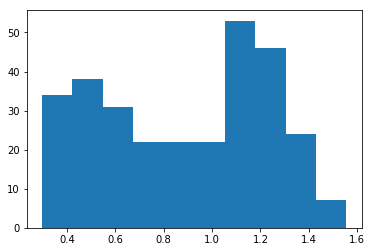

In [15]:
plt.hist(distances_from_centroids)

In [16]:
import pickle
def save_obj(obj, name ):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [17]:
save_obj(cluster_centers_dict, 'cluster_center_dict.pkl')
save_obj(subset_test_images, 'subset_test_images.pkl')

(array([27., 30., 21., 12., 16., 10., 25., 44., 18., 10.]),
 array([0.30391783, 0.42158385, 0.53924987, 0.6569159 , 0.77458192,
        0.89224795, 1.00991397, 1.12757999, 1.24524602, 1.36291204,
        1.48057806]),
 <a list of 10 Patch objects>)

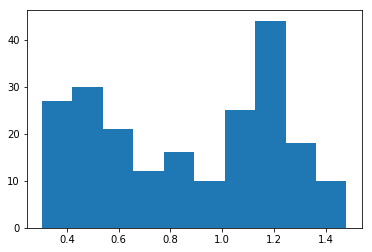

In [20]:
plt.hist(distances_from_centroids_to_positives)

(array([ 7.,  7.,  9.,  6.,  9.,  8., 13., 15.,  7.,  5.]),
 array([0.29699877, 0.4228686 , 0.54873843, 0.67460826, 0.80047809,
        0.92634793, 1.05221776, 1.17808759, 1.30395742, 1.42982725,
        1.55569708]),
 <a list of 10 Patch objects>)

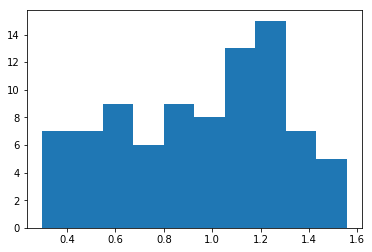

In [21]:
plt.hist(distances_from_centroids_to_negatives)

In [23]:
len(distances_from_centroids_to_positives)

213